### Data Dictionary

You work for a bank as a business data analyst in the credit card risk-modeling department. Your bank conducted a bold experiment three years ago: for a single day it quietly issued credit cards to everyone who applied, regardless of their credit risk, until the bank had issued 600 cards without screening applicants.

After three years, 150, or 25%, of those card recipients defaulted: they failed to pay back at least some of the money they owed. However, the bank collected very valuable proprietary data that it can now use to optimize its future card-issuing process.

The bank initially collected six pieces of data about each person:

· Age

· Years at current employer

· Years at current address

· Income over the past year

· Current credit card debt, and

· Current automobile debt

In addition, the bank now has a binary outcome: default = 1, and no default = 0.

Your first assignment is to analyze the data and create a binary classification model to forecast future defaults.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score


#import feature_engine.missing_data_imputers as mdi
#from feature_engine.outlier_removers import Winsorizer

#from tpot import TPOTClassifier, TPOTRegressor
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

np.random.seed(0)

from pycaret.classification import *
#from pycaret.clustering import *
#from pycaret.regression import *

pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)

### Data Exploration and Analysis

In [2]:
df = pd.read_csv("trainset.csv")

In [3]:
df

,ID,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt,Default
0,1,32.53,9.39,0.30,37844,3247,4795,0
1,2,34.58,11.97,1.49,65765,15598,17632,1
2,3,37.70,12.46,0.09,61002,11402,7910,1
3,4,28.68,1.39,1.84,19953,1233,2408,0
4,5,32.61,7.49,0.23,24970,1136,397,0
...,...,...,...,...,...,...,...,...
195,196,42.20,13.25,0.58,58644,5165,11395,0
196,197,24.60,7.82,1.93,17453,984,1432,0
197,198,24.97,2.37,0.31,27214,1446,2101,0
198,199,38.96,16.69,0.69,115211,3206,25827,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               200 non-null    int64  
 1   Age              200 non-null    float64
 2   YearsatEmployer  200 non-null    float64
 3   YearsatAddress   200 non-null    float64
 4   Income           200 non-null    int64  
 5   CreditCardDebt   200 non-null    int64  
 6   AutomobileDebt   200 non-null    int64  
 7   Default          200 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 12.6 KB


In [5]:
df.describe(include='all')

,ID,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt,Default
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,34.666050,8.614550,0.779300,48439.950000,3202.745000,6440.955000,0.250000
std,57.879185,8.223616,6.790097,0.620515,47982.450328,3901.238377,7436.937137,0.434099
min,1.000000,20.190000,0.040000,0.010000,11522.000000,27.000000,34.000000,0.000000
25%,50.750000,28.500000,3.400000,0.310000,23208.000000,810.750000,2101.000000,0.000000
50%,100.500000,33.130000,7.500000,0.620000,33884.000000,1822.000000,3922.500000,0.000000
75%,150.250000,40.227500,12.520000,1.052500,58330.500000,4242.500000,7902.500000,0.250000
max,200.000000,55.720000,31.650000,3.700000,451320.000000,32050.000000,55419.000000,1.000000


In [6]:
df.shape

(200, 8)

In [7]:
df.columns

Index(['ID', 'Age', 'YearsatEmployer', 'YearsatAddress', 'Income', 'CreditCardDebt', 'AutomobileDebt', 'Default'], dtype='object')

### Data Visualization

### Univariate Data Exploration

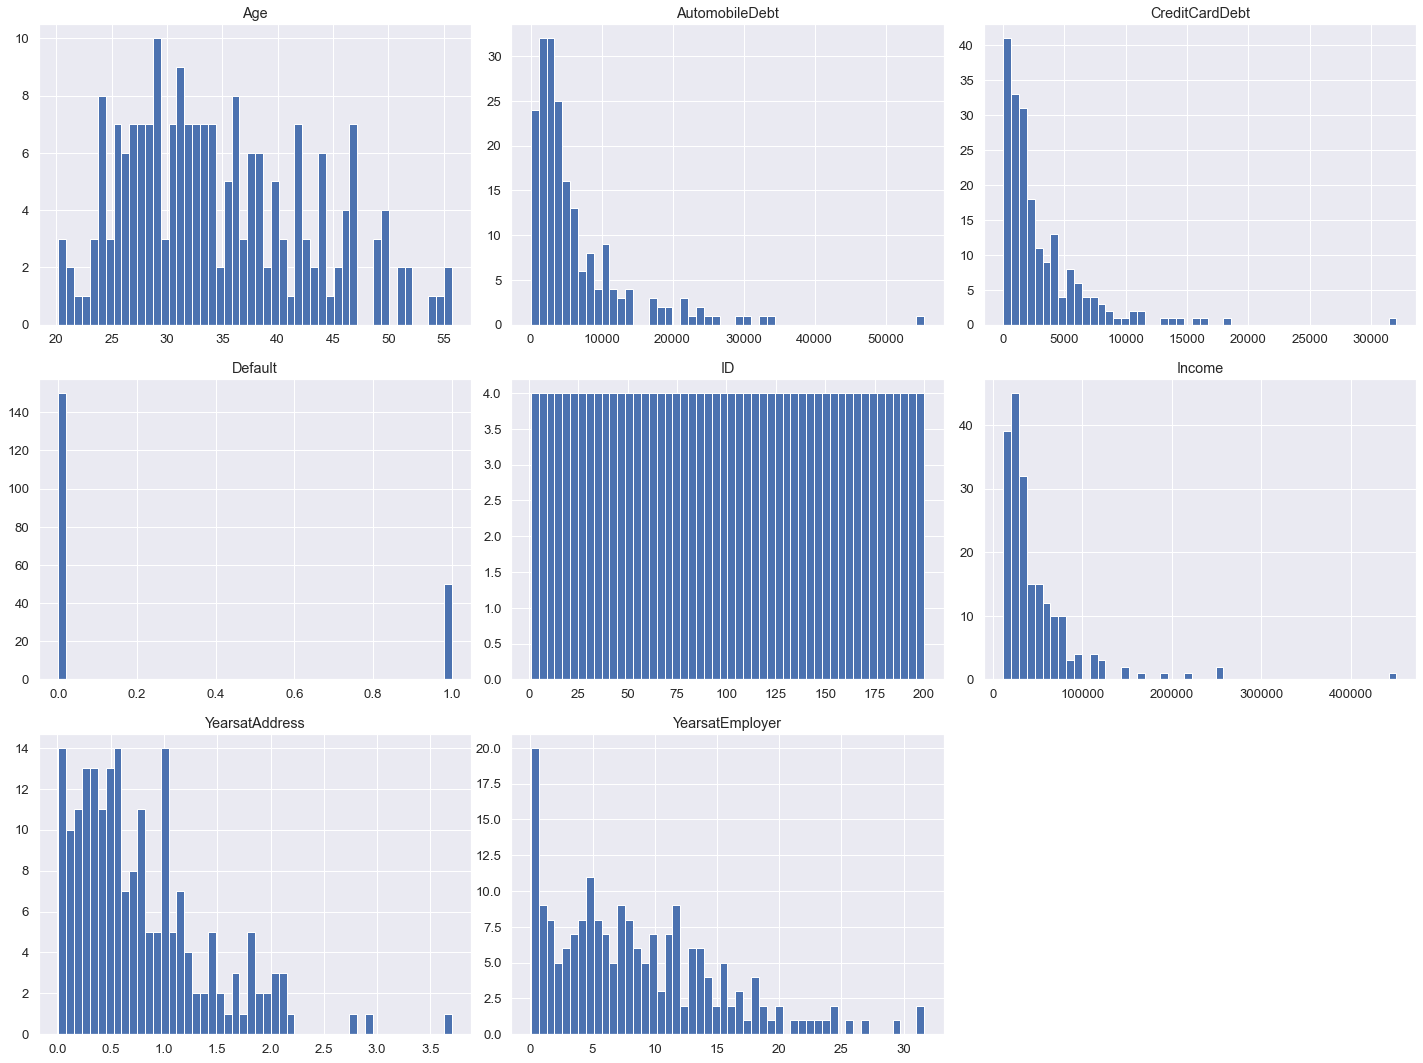

In [8]:
df.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

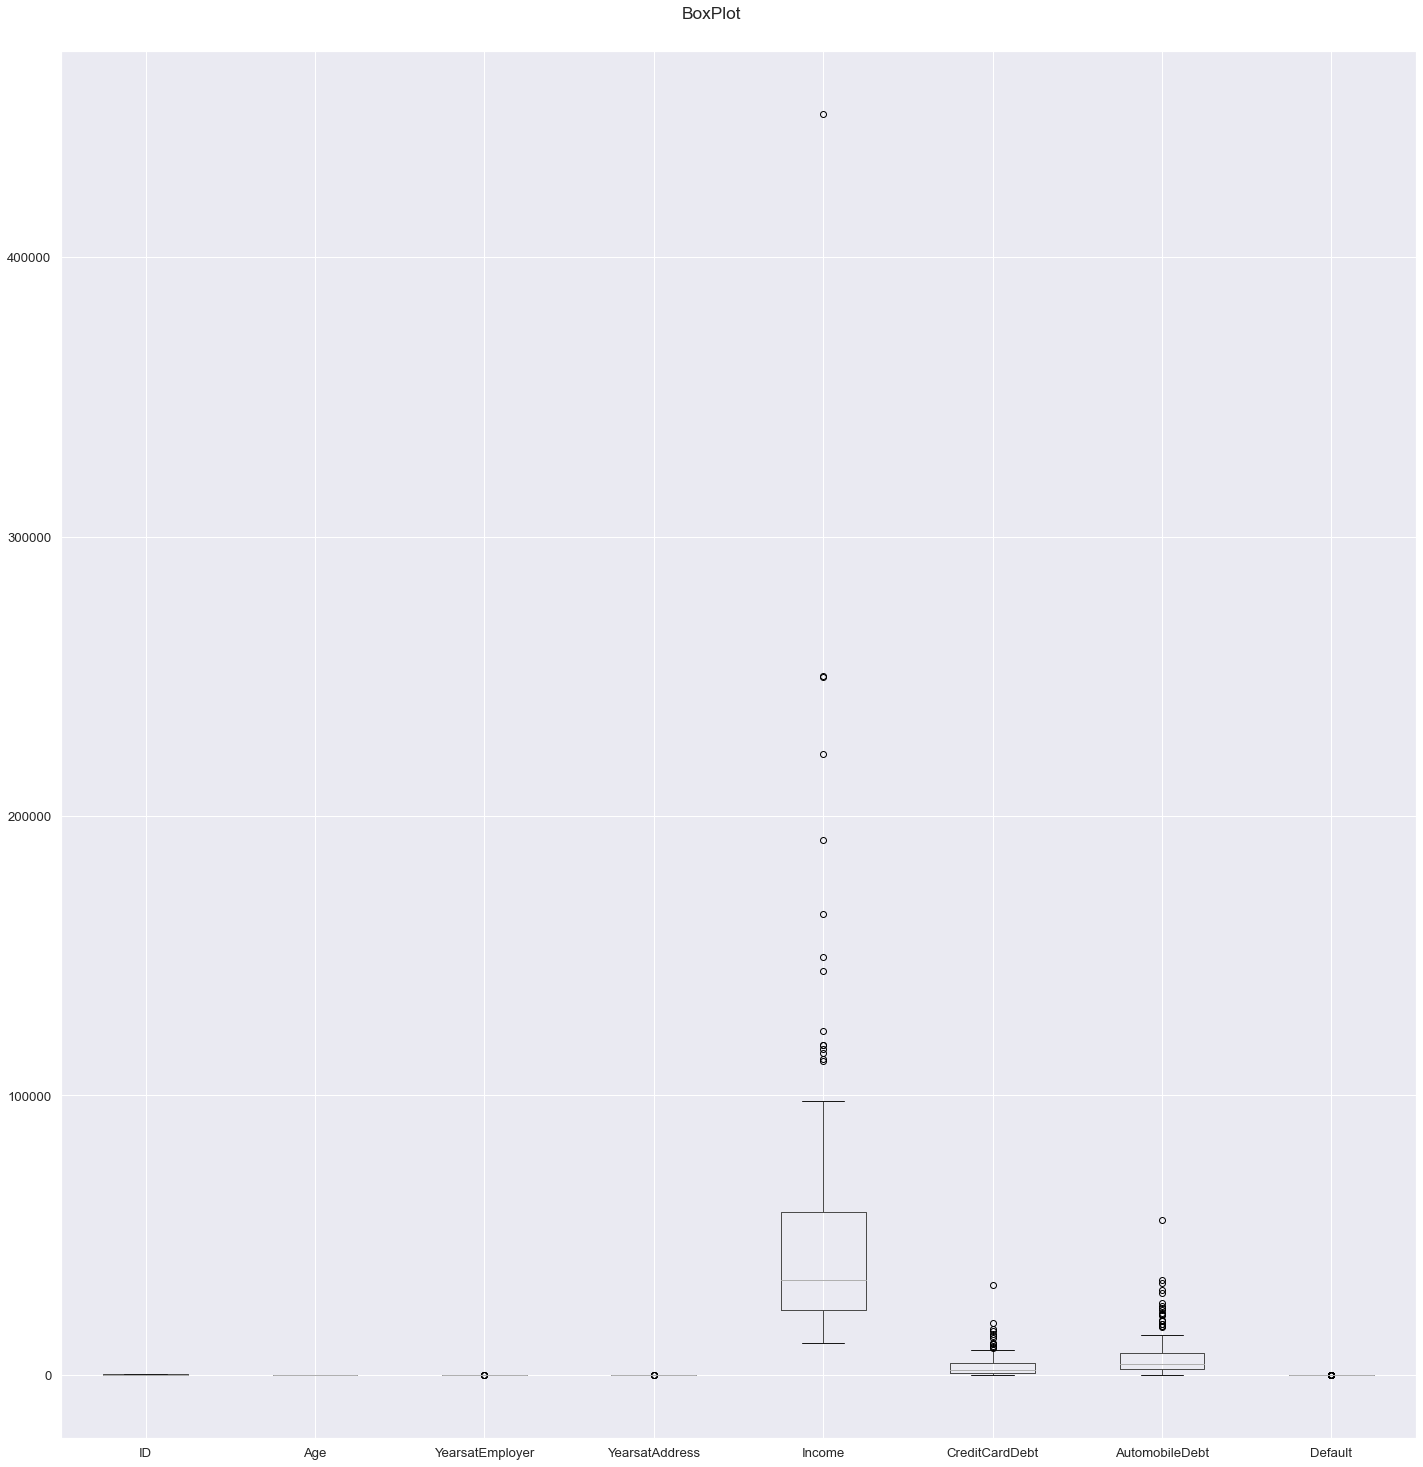

In [9]:
df.boxplot(figsize=(20,20))

plt.suptitle('BoxPlot', x=0.5, y=1.02, ha='center', fontsize='large')

plt.tight_layout()

plt.show()

### Correlation

In [10]:
df.corr()

,ID,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt,Default
ID,1.000000,-0.108655,-0.050498,-0.107489,-0.124132,-0.079379,-0.102470,-0.019200
Age,-0.108655,1.000000,0.539530,0.076249,0.457726,0.302186,0.336960,-0.180464
YearsatEmployer,-0.050498,0.539530,1.000000,0.069504,0.612239,0.441281,0.445990,-0.306542
YearsatAddress,-0.107489,0.076249,0.069504,1.000000,0.131131,0.097256,0.090133,0.071917
Income,-0.124132,0.457726,0.612239,0.131131,1.000000,0.710714,0.655243,-0.053031
CreditCardDebt,-0.079379,0.302186,0.441281,0.097256,0.710714,1.000000,0.600914,0.197628
AutomobileDebt,-0.102470,0.336960,0.445990,0.090133,0.655243,0.600914,1.000000,0.099322
Default,-0.019200,-0.180464,-0.306542,0.071917,-0.053031,0.197628,0.099322,1.000000


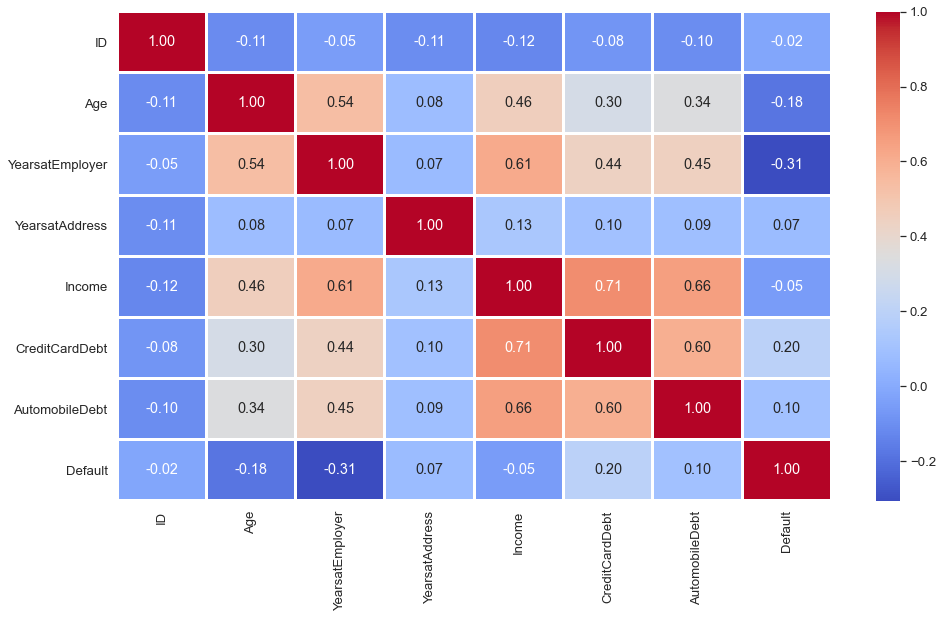

In [11]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

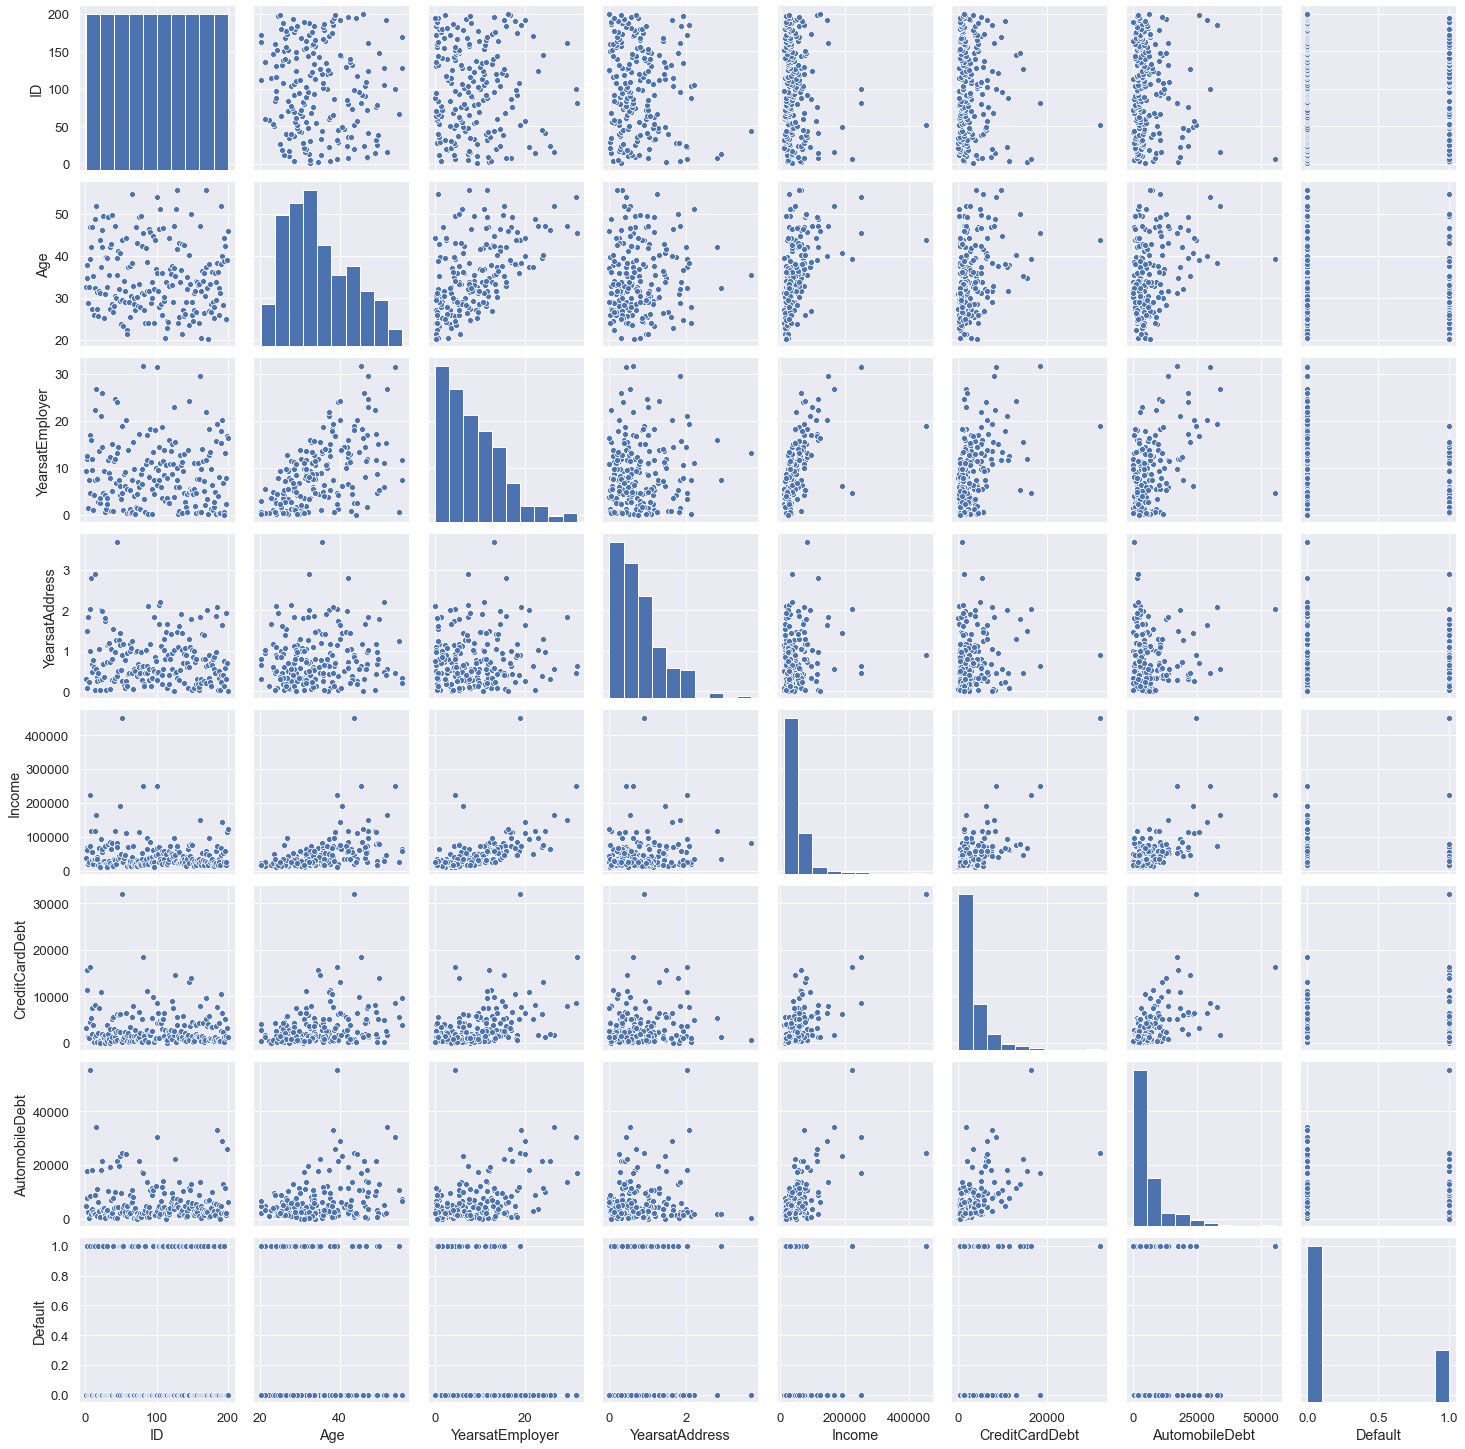

In [12]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [13]:
df.isnull().sum()

ID                 0
Age                0
YearsatEmployer    0
YearsatAddress     0
Income             0
CreditCardDebt     0
AutomobileDebt     0
Default            0
dtype: int64

### Treat Duplicate Values

In [14]:
df.duplicated(keep='first').sum()

0

### Drop unwanted features

In [15]:
df.columns

Index(['ID', 'Age', 'YearsatEmployer', 'YearsatAddress', 'Income', 'CreditCardDebt', 'AutomobileDebt', 'Default'], dtype='object')

In [16]:
df.drop(['ID'],axis=1,inplace=True)

In [17]:
df

,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt,Default
0,32.53,9.39,0.30,37844,3247,4795,0
1,34.58,11.97,1.49,65765,15598,17632,1
2,37.70,12.46,0.09,61002,11402,7910,1
3,28.68,1.39,1.84,19953,1233,2408,0
4,32.61,7.49,0.23,24970,1136,397,0
...,...,...,...,...,...,...,...
195,42.20,13.25,0.58,58644,5165,11395,0
196,24.60,7.82,1.93,17453,984,1432,0
197,24.97,2.37,0.31,27214,1446,2101,0
198,38.96,16.69,0.69,115211,3206,25827,0


### Create and save processed dataset

In [18]:
#df.to_csv("",index=False)

In [19]:
df.shape

(200, 7)

### Train Test Split

In [20]:
X = df.iloc[:,0:6]
y = df.iloc[:,6]

### Treat Imbalance Data

In [21]:
y.value_counts()

0    150
1     50
Name: Default, dtype: int64

In [22]:
ros = RandomUnderSampler(sampling_strategy='all',random_state=0)

In [23]:
new_X, new_y = ros.fit_resample(X, y)

In [24]:
new_y.value_counts()

1    50
0    50
Name: Default, dtype: int64

In [25]:
new_X

,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt
0,33.93,4.60,0.80,16859,1908,2807
1,41.79,10.79,1.01,35485,2862,4971
2,29.91,6.77,1.26,19060,2338,4486
3,23.44,4.83,0.60,22267,646,3964
4,25.97,4.21,0.60,35387,191,1661
...,...,...,...,...,...,...
95,25.80,3.63,0.18,19828,2952,4217
96,38.66,0.61,0.13,30129,1210,2707
97,35.17,15.51,0.46,47201,14557,22228
98,27.99,6.90,0.68,29452,822,1067


### Train Test Split

In [26]:
X.values, y.values

(array([[3.25300e+01, 9.39000e+00, 3.00000e-01, 3.78440e+04, 3.24700e+03,
         4.79500e+03],
        [3.45800e+01, 1.19700e+01, 1.49000e+00, 6.57650e+04, 1.55980e+04,
         1.76320e+04],
        [3.77000e+01, 1.24600e+01, 9.00000e-02, 6.10020e+04, 1.14020e+04,
         7.91000e+03],
        ...,
        [2.49700e+01, 2.37000e+00, 3.10000e-01, 2.72140e+04, 1.44600e+03,
         2.10100e+03],
        [3.89600e+01, 1.66900e+01, 6.90000e-01, 1.15211e+05, 3.20600e+03,
         2.58270e+04],
        [4.58700e+01, 1.64100e+01, 1.00000e-02, 1.23171e+05, 1.19500e+03,
         6.47000e+03]]),
 array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 6), (40, 6), (160,), (40,))

### Feature Scaling

In [29]:
X_train

,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt
134,42.73,11.33,1.44,31997,773,3863
66,32.72,15.56,0.06,74098,7920,8218
26,39.68,4.29,1.74,73553,1711,1285
113,22.86,3.54,1.67,15752,39,3395
168,55.58,11.74,0.20,57901,9563,6763
...,...,...,...,...,...,...
67,30.01,4.04,0.57,17915,498,307
192,28.27,6.85,0.39,52054,2459,13117
117,32.68,15.82,0.40,57887,1614,2516
47,29.26,4.33,1.14,38367,2460,2224


In [30]:
scaler = StandardScaler()

In [31]:
X_train_scaled = scaler.fit_transform(X_train)

In [32]:
X_test_scaled = scaler.transform(X_test)

In [33]:
X_train_scaled

array([[ 9.15666344e-01,  4.24225133e-01,  1.12840498e+00,
        -3.39080491e-01, -6.26637119e-01, -3.64738574e-01],
       [-2.65286786e-01,  1.05720992e+00, -1.18971764e+00,
         5.44815523e-01,  1.27898764e+00,  2.73881810e-01],
       [ 5.55835470e-01, -6.29253096e-01,  1.63234468e+00,
         5.33373436e-01, -3.76535535e-01, -7.42778379e-01],
       [-1.42854332e+00, -7.41484442e-01,  1.51475875e+00,
        -6.80138678e-01, -8.22345609e-01, -4.33366436e-01],
       [ 2.43167511e+00,  4.85578269e-01, -9.54545780e-01,
         2.04765079e-01,  1.71706536e+00,  6.05195462e-02],
       [-5.29556018e-01, -1.21884176e+00,  4.90081357e-01,
        -6.90405065e-01, -4.05065246e-01, -6.95507823e-02],
       [ 1.39347455e+00,  5.18499463e-01, -1.65040251e-01,
         1.49066257e-01,  1.14967072e+00,  1.74248873e+00],
       [ 1.67308084e+00,  1.29065112e+00, -5.84990001e-01,
         1.36081482e+00,  9.34764671e-01,  2.24502652e+00],
       [ 2.07802330e-01,  3.62871998e-01,  3.653

In [34]:
X_test_scaled

array([[-0.41039891,  0.76840126,  0.45648538,  0.41271715,  1.16966818,
        -0.47193295],
       [-0.30657885, -0.76243429,  2.10268839, -0.49887082,  0.14846449,
        -0.53176237],
       [-1.08168995, -0.72801668, -0.98814176, -0.59456446, -0.04564421,
        -0.31282776],
       [ 0.21134165,  0.2296908 , -0.03065633, -0.0404525 , -0.55891238,
         0.86440403],
       [ 0.14527434, -0.32398384, -0.19863623, -0.25906986,  0.06607495,
         0.5398881 ],
       [-0.15202854,  1.09312395,  1.85071854,  0.23543827,  0.14873112,
        -0.05547327],
       [ 0.51336363, -0.58585698,  2.11948638,  3.65219258,  3.52750221,
         7.19547096],
       [-0.20039925, -0.45267578,  0.55727332, -0.06671682,  0.11513538,
         0.64297653],
       [-0.31011817, -0.16386712,  3.58091151, -0.27376612, -0.4818555 ,
        -0.64511565],
       [-0.46348871,  0.36885767,  0.38929342, -0.41955301, -0.73915617,
        -0.51020618],
       [ 0.29864488, -0.47362563,  0.67485925, -0.

### Model Training

### Using PyCaret

In [35]:
exp = setup(data = df, target = 'Default', session_id=0, normalize=True, fix_imbalance=True ) 

Setup Succesfully Completed!


,Description,Value
0,session_id,0
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(200, 7)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [36]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Random Forest Classifier,0.7758,0.7001,0.4083,0.5167,0.4460,0.3167,0.3216,0.0260
1,Ada Boost Classifier,0.7330,0.7214,0.5250,0.4705,0.4818,0.3075,0.3175,0.1018
2,CatBoost Classifier,0.7264,0.7113,0.4917,0.4333,0.4555,0.2733,0.2789,2.0237
3,Extra Trees Classifier,0.7115,0.7434,0.3917,0.4217,0.3964,0.2211,0.2204,0.1576
4,Ridge Classifier,0.7055,0.0000,0.7917,0.4599,0.5739,0.3796,0.4176,0.0029
5,Linear Discriminant Analysis,0.7055,0.7678,0.7917,0.4599,0.5739,0.3796,0.4176,0.0034
6,Extreme Gradient Boosting,0.7049,0.7027,0.4500,0.4333,0.4257,0.2303,0.2400,0.1099
7,Logistic Regression,0.6984,0.7639,0.7250,0.4462,0.5470,0.3473,0.3718,0.0047
8,SVM - Linear Kernel,0.6973,0.0000,0.6417,0.4755,0.5230,0.3249,0.3461,0.0047
9,Decision Tree Classifier,0.6907,0.6479,0.5667,0.4169,0.4672,0.2593,0.2755,0.0038


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [37]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7143,0.4242,0.0000,0.0000,0.0000,-0.1200,-0.1448
1,0.7857,0.7273,0.3333,0.5000,0.4000,0.2759,0.2843
2,0.7143,0.5909,0.0000,0.0000,0.0000,-0.1200,-0.1448
3,0.8571,0.6667,0.6667,0.6667,0.6667,0.5758,0.5758
4,0.9286,0.7750,0.7500,1.0000,0.8571,0.8108,0.8257
5,0.5714,0.6000,0.2500,0.2500,0.2500,-0.0500,-0.0500
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.8571,0.9125,0.5000,1.0000,0.6667,0.5882,0.6455
8,0.7143,0.5375,0.2500,0.5000,0.3333,0.1765,0.1936
9,0.6154,0.7667,0.3333,0.2500,0.2857,0.0299,0.0304


In [38]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [39]:
tuned_rf = tune_model(rf, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5000,0.4848,0.0000,0.0000,0.0000,-0.3243,-0.3303
1,0.7857,0.6061,0.3333,0.5000,0.4000,0.2759,0.2843
2,0.7857,0.5152,0.3333,0.5000,0.4000,0.2759,0.2843
3,0.8571,0.7576,0.6667,0.6667,0.6667,0.5758,0.5758
4,0.8571,0.7750,0.7500,0.7500,0.7500,0.6500,0.6500
5,0.5714,0.7000,0.5000,0.3333,0.4000,0.0870,0.0913
6,0.7857,0.8500,0.5000,0.6667,0.5714,0.4324,0.4404
7,0.7857,0.8250,0.7500,0.6000,0.6667,0.5116,0.5185
8,0.5714,0.7500,0.5000,0.3333,0.4000,0.0870,0.0913
9,0.5385,0.7000,0.3333,0.2000,0.2500,-0.0541,-0.0577


In [40]:
print(tuned_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


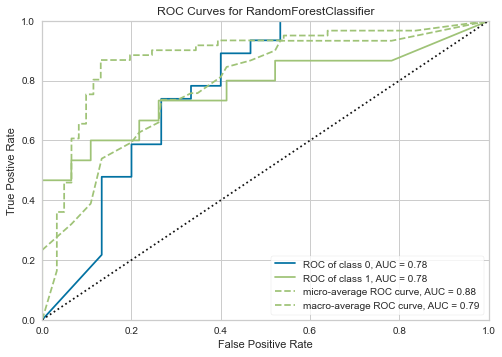

In [41]:
plot_model(tuned_rf)

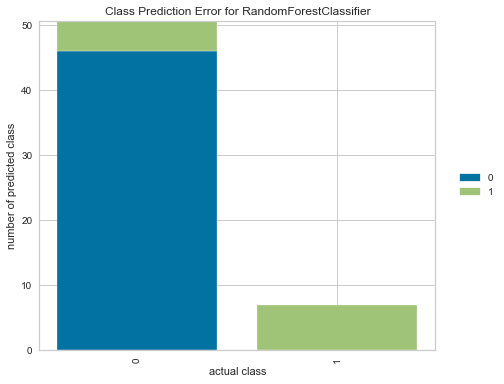

In [42]:
plot_model(tuned_rf, plot = 'error')

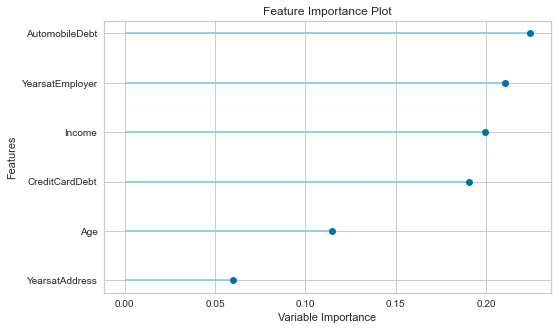

In [43]:
plot_model(tuned_rf, plot='feature')

In [44]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [45]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8689,0.7754,0.4667,1.0,0.6364,0.5689,0.6305


,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt,Default,Label,Score
0,-0.522496,0.470309,-0.742049,-0.342126,-0.731277,-0.838728,0,0,0.0500
1,0.602698,-1.096182,-1.226732,-0.586744,-0.668833,-0.448748,0,0,0.0833
2,-0.749241,-1.075512,-0.111962,-0.365046,0.057627,-0.293996,0,0,0.3714
3,0.255265,0.208981,-0.047337,-0.046361,-0.559106,0.782393,0,0,0.2375
4,0.567345,-0.595673,2.020642,3.628449,3.379249,6.602308,1,1,0.5750
...,...,...,...,...,...,...,...,...,...
56,-1.127150,-1.074035,0.340409,-0.421353,0.079727,0.329730,1,1,0.6924
57,0.061435,1.018064,-0.515864,-0.025886,2.917727,2.128116,1,1,0.5619
58,0.168712,-0.663588,-1.194420,-0.650824,-0.589171,-0.401837,0,0,0.3869
59,1.098856,1.403412,0.114224,-0.034515,-0.580434,-0.659577,0,0,0.0000


In [46]:
final_rf = finalize_model(tuned_rf)

In [47]:
unseen_predictions = pd.read_csv("testset.csv")

In [48]:
unseen_predictions

,ID,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt
0,201,25.92,0.35,0.24,12181,2057,3696
1,202,27.80,4.47,0.37,38536,6970,3018
2,203,37.33,9.30,0.02,30602,2892,1674
3,204,28.00,8.43,1.06,15588,38,1758
4,205,39.24,5.40,0.74,27599,776,4374
...,...,...,...,...,...,...,...
195,396,49.66,16.02,0.24,70526,3100,13605
196,397,23.78,2.97,0.70,17318,122,104
197,398,32.84,3.97,0.75,29403,442,3908
198,399,43.89,13.97,0.08,43730,244,2535


In [49]:
unseen_predictions.drop(['ID'],axis=1,inplace=True)

In [50]:
unseen_predictions

,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt
0,25.92,0.35,0.24,12181,2057,3696
1,27.80,4.47,0.37,38536,6970,3018
2,37.33,9.30,0.02,30602,2892,1674
3,28.00,8.43,1.06,15588,38,1758
4,39.24,5.40,0.74,27599,776,4374
...,...,...,...,...,...,...
195,49.66,16.02,0.24,70526,3100,13605
196,23.78,2.97,0.70,17318,122,104
197,32.84,3.97,0.75,29403,442,3908
198,43.89,13.97,0.08,43730,244,2535


In [51]:
unseen_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    float64
 1   YearsatEmployer  200 non-null    float64
 2   YearsatAddress   200 non-null    float64
 3   Income           200 non-null    int64  
 4   CreditCardDebt   200 non-null    int64  
 5   AutomobileDebt   200 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 9.5 KB


In [52]:
predictions = predict_model(final_rf, data=unseen_predictions)
predictions

,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt,Label,Score
0,25.92,0.35,0.24,12181,2057,3696,1,0.9167
1,27.80,4.47,0.37,38536,6970,3018,0,0.2493
2,37.33,9.30,0.02,30602,2892,1674,0,0.0542
3,28.00,8.43,1.06,15588,38,1758,0,0.2117
4,39.24,5.40,0.74,27599,776,4374,0,0.1655
...,...,...,...,...,...,...,...,...
195,49.66,16.02,0.24,70526,3100,13605,0,0.0600
196,23.78,2.97,0.70,17318,122,104,0,0.1250
197,32.84,3.97,0.75,29403,442,3908,0,0.0821
198,43.89,13.97,0.08,43730,244,2535,0,0.0917


In [54]:
data2 = pd.read_csv("week6test.csv")

In [55]:
data2

,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt
0,-0.06,0.23,-0.58,-0.38,0.14,-0.06


In [56]:
predictions2 = predict_model(final_rf, data=data2)
predictions2

,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt,Label,Score
0,-0.06,0.23,-0.58,-0.38,0.14,-0.06,0,0.425
